In [1]:
from jax.config import config
# config.update("jax_enable_x64", True)

import jax.numpy as np
import numpy.random as npr

from jax import jacfwd, grad, jit, partial
from jax.lax import scan
from jax.ops import index, index_add, index_update
from scipy.linalg import logm
import scipy.linalg

In [2]:
state_dim = 4
num_x_obs = 7
num_u_obs = 2
num_obs = num_x_obs + num_u_obs

@jit
def f(s, a):
    th, x, thdot, xdot = s
    sdot = np.array([
                thdot, xdot, 
                9.81*np.sin(th)/2.0+a[0]*np.cos(th)/2.0-0.2*thdot,
                a[0]])
    return s + sdot/60.
@jit
def z(s):
    th, x, thdot, xdot = s
    return np.array([th, x, thdot, xdot, np.sin(th), np.cos(th), 1.0])
@jit
def v(z, u):
    th, x, thdot, xdot = z[:state_dim]
    return np.array([u[0] * np.cos(th), u[0]])


Provided a data set $\mathcal{D} = \{(x(t_m), u(t_m), x(t_{m+1}), u(t_{m+1})) \}_{m=0}^{M-1}$, we can compute the approximate Koopman operator $\mathfrak{K}$ using least-squares minimization over the matrix $\mathfrak{K}$:
$$
    \min_{\mathfrak{K}} \frac{1}{2 M} \sum_{m=0}^{M-1} \Vert z(x(t_{m+1}), u(t_{m+1})) - \mathfrak{K} z(x(t_m), u(t_m)) \Vert^2.
$$
Since this optimization is convex in $\mathfrak{K}$, the solution is given by
$$
    \mathfrak{K} = A G^\dagger
$$        
where $\dagger$ denotes the Moore-Penrose pseudoinverse and
$$
A = \frac{1}{M} \sum_{m=0}^{M-1} z(x(t_{m+1}), u(t_{m+1})) z(x(t_m), u(t_m))^\top, \\
            G = \frac{1}{M} \sum_{m=0}^{M-1} z(x(t_m), u(t_m)) z(x(t_m), u(t_m))^\top .
$$
The continuous time operator is then given by $\log(\mathfrak{K})/t_s$.
Note that we can solve the optimization using gradient descent methods or other
optimization methods.

In the next cell, we will collect some data and learn a Koopman operator for the functions of state described previously.

In [3]:
def wrap2Pi(th):
    th = np.fmod(th+np.pi, 2.0 * np.pi)
    if th < 0:
        th = th + 2.0 * np.pi
    return th - np.pi

def ell(z):
    th, x, thdot, xdot = z[:state_dim]
    return -80.*np.cos(th) + 0.1 * (x**4) + 0.1*(np.square(thdot) + np.square(xdot)) 



In [4]:
npr.seed(0) ## set the seed for reproducibility 
num_trials = 600 ## number of resets
horizon    = 10 ## how long we simulate the system for
M = num_trials * horizon ## M sized data

_A = np.zeros((num_obs, num_obs))
_G = np.zeros((num_obs, num_obs))

s_bnds = np.array([6.24, 2.0, 6.0, 1.0])
a_bnds = np.array([4.8])
## loop to collect data
for k in range(num_trials):
#     x_t = npr.uniform(low=-s_bnds, high=s_bnds)
    x_t = npr.normal(s_bnds*0., s_bnds)
    for t in range(horizon):
        u_t = npr.normal(0.*a_bnds, a_bnds)
        x_tpo = f(x_t, u_t)
        u_tpo = u_t

        z1 = np.concatenate([z(x_t), v(x_t, u_t)])
        z2 = np.concatenate([z(x_tpo), v(x_tpo, u_t)])
        _A += np.outer(z2, z1)
        _G += np.outer(z1, z1)
        
        # reset for next loop
        x_t = x_tpo
        u_t = u_tpo
_A /= M
_G /= M

koopman_operator = np.dot(_A, np.linalg.pinv(_G))

/home/burn/.local/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Extract out the A and B matrices

In [5]:
A = koopman_operator[:num_x_obs,:num_x_obs]
B = koopman_operator[:num_x_obs, num_x_obs:]

In [6]:
def sim_step(z, i, K, A, B):
    u = np.dot(K, z)
    zn = np.dot(A, z) + np.dot(B, v(z, u))
    return zn, ell(zn)
# control objective
def J(x0, K, A, B, T):   
    zf, lt = scan(partial(sim_step, A=A, B=B, K=K), z(x0), None, length=T)
    return np.sum(lt) + ell(zf)
# contro updater
dJ = jit(grad(J, argnums=1), static_argnums=4)
def replan(x0, K, A, B, T):
    dK = dJ(x0, K, A, B, T)
    return K - 0.001* dK

Here we calculate the continuous time Koopman operator.

For optimal control with the Koopman operator, we split $\mathfrak{K}$ into the free dynamics $A$ and dynamic actuation matrix $B$. 

Since the Koopman operator representation of the dynamical system is linear, we can directly apply LQR control.

In [7]:
np.set_printoptions(precision=3, suppress=True)

Note that the augmented state observables show up in the linear dynamics embedding as part of the update equation $z_{t+1} = Az_t + Bv_t$

In [8]:
A

DeviceArray([[ 1.   , -0.   ,  0.017,  0.   , -0.   ,  0.   , -0.   ],
             [-0.   ,  1.   ,  0.   ,  0.017, -0.   ,  0.   ,  0.   ],
             [-0.   , -0.   ,  0.997, -0.   ,  0.082,  0.   , -0.   ],
             [-0.   ,  0.   , -0.   ,  1.   ,  0.   , -0.   , -0.   ],
             [ 0.   ,  0.002, -0.001, -0.001,  0.997,  0.006, -0.002],
             [-0.   , -0.003,  0.   ,  0.001, -0.003,  0.994, -0.005],
             [ 0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   ,  1.   ]],            dtype=float32)

In [9]:
B

DeviceArray([[-0.   ,  0.   ],
             [ 0.   , -0.   ],
             [ 0.008,  0.   ],
             [ 0.   ,  0.017],
             [ 0.   ,  0.   ],
             [ 0.   ,  0.   ],
             [ 0.   ,  0.   ]], dtype=float32)

The controller can then be tested on the true actuated dynamical system.

In [10]:
x_t = np.array([3.4, 0., 0., 0.])
horizon = int(1.1 * 60) # simulation time
K = np.zeros((1, num_x_obs))
trajectory = []

for t in range(int(6*60)):
    for _ in range(1):
        K = replan(x_t, K, A, B, horizon)
    u = np.dot(K, z(x_t))
    x_tpo = f(x_t,u)
    
    x_t = x_tpo
    x_t = index_update(x_t, index[0], wrap2Pi(x_t[0]))
    trajectory.append(x_t)
    if t %  20 == 0:
        print(x_t)

[-2.883  0.    -0.038  0.036]
[-3.084  0.283 -1.276  1.982]
[ 2.748  1.064 -1.422  2.979]
[ 2.392  2.105 -0.15   2.134]
[ 2.829  1.952  2.763 -3.014]
[-2.334  0.468  3.527 -5.76 ]
[-1.391 -1.461  1.937 -4.57 ]
[-0.846 -2.082  1.634  1.259]
[-0.239 -1.021  1.845  4.315]
[0.219 0.173 0.735 2.227]
[ 0.315  0.471 -0.085 -0.41 ]
[ 0.207  0.005 -0.608 -2.475]
[-0.058 -1.033 -0.844 -3.353]
[-0.256 -1.929 -0.23  -1.623]
[-0.226 -2.109  0.367  0.494]
[-0.076 -1.781  0.458  1.261]
[ 0.043 -1.403  0.218  0.87 ]
[ 0.073 -1.225 -0.031  0.174]


Here we visualize the resulting trajectory from applying a model-based controller using the Koopman operator representation of the dynamical system.

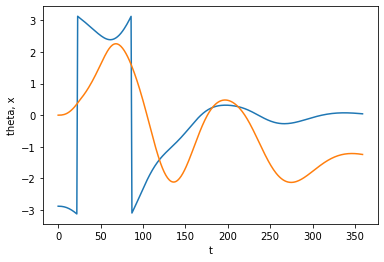

In [11]:
import matplotlib.pyplot as plt
trajectory = np.stack(trajectory)
plt.plot(trajectory[:,0])
plt.plot(trajectory[:,1])
plt.xlabel('t')
plt.ylabel('theta, x')
plt.show()